# WeatherPy Analysis¶
•	The co-ordinate data was randomly chosen to give a uniform distribution of the Cities around the globe.

•	Temperature vs Latitude: The Max Temp vs Latititude plot clearly shows that the Cities with Latitude values closer to 0 (closer to Equator) have higher max temeratures than the cities away from the Equator. The max temperature is around 80 F within 20 S - 16 N degrees and then falls to about 10 F as the latitude increases in the northern hemisphere. This implies that on average the southern hemisphere is warmer than the northern hemisphere.

•	Humidity vs Latitude: There is no clear relation between the humidity and latitude. Although, if we take a closer look, we can see that the humidity is between 60-100%  in the cities that lie between 40deg S and 70deg N. We may need to further study the humidity data with the Longitude data to see how the oceans and land temperatures and cloud cover affect it.

•	Cloudiness vs Latitude: There is no clear relation between the cloudiness and latitude based on our data. We can see a cloudiness of 0% as well as 80% throughout the range of our data. This does not show a clear pattern.  The cloudiness varies seasonally and this may be the reason why our current datapoints (single date stamp) may not reflect a pattern. We may need to further collect more data on a seasonal and the time of the day basis.

•	Wind Speeds vs Latitude: There is no clear relation between the wind speeds and latitude based on our data. Most of the windspeed seems to be between 0-10mph throughout the range of latitudes considered in our data.




In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import time
from citipy import citipy
from config import api_key
import warnings
warnings.filterwarnings(action='once')


In [2]:
# create empty dictionary for latitude and longitude
coords = {"Latitude": [], "Longitude": []}

# define a function to generate 100 random numbers (with random.uniform for uniform distribution of data) for 
# latitude and longitude in the given ranges. We'll be calling this function multiple times to get to 500 cities 
# with proper data.

def get_coord():    
    #coords = {"Latitude": [], "Longitude": []}
    for x in range(100):
        lat = np.random.uniform(low=-90, high=90)
        long = np.random.uniform(low=-180, high=180)
        coords["Latitude"].append(lat)
        coords["Longitude"].append(long)
        
# call the lat/long function and create a base dataframe with the lat and long values
get_coord()
lat_long_df = pd.DataFrame(coords)

# print the dataframe
lat_long_df.head()

,Latitude,Longitude
0,-30.042485,159.931024
1,-21.669445,31.968035
2,81.111269,-9.443372
3,82.547830,47.729042
4,53.407040,148.438182


In [3]:
# get the nearest cities to the coordinates in the dataframe

# create emptylist for the cities
cities = []

# create a loop to run through all the coordinate rows in the dataframe and get the nearest city using citypy
for index, row in lat_long_df.iterrows():
    city = citipy.nearest_city(row["Latitude"], row["Longitude"])
    city_name = city.city_name
    # add the city name to the list
    cities.append(city_name)

# assign the dataframe to df
df= lat_long_df

# create a function for getting city names using df as the dataframe
def get_cities():
    for index, row in df.iterrows():
        city = citipy.nearest_city(row["Latitude"], row["Longitude"])
    #print(city)
        city_name = city.city_name
        cities.append(city_name)
    
# add the cities to the cities column in the base dataframe
lat_long_df["Cities"] = cities

# print the dataframe
lat_long_df.head()

,Latitude,Longitude,Cities
0,-30.042485,159.931024,byron bay
1,-21.669445,31.968035,chiredzi
2,81.111269,-9.443372,illoqqortoormiut
3,82.547830,47.729042,belushya guba
4,53.407040,148.438182,vostok


In [4]:
# get the count of unique cities in the dataframe
cities_unique = lat_long_df["Cities"].unique()
print(f"Unique Cities: {len(cities_unique)}")

Unique Cities: 83


In [5]:
# call the lat/long function and cities function multiple times till we get >=500 non-repeating cities in the dataframe

while len(cities_unique) < 600:
    coord = []
    get_coord()
    
    # add the new co-ordinates to a nother dataframe
    new_data_df = pd.DataFrame(coords)
    
    # assign the dataframe to df
    df = new_data_df
    
    cities = []
    get_cities()
    # add the cities to the cities column in this new dataframe
    df["Cities"] = cities
    
    # append the new dataframe to the base dataframe
    lat_long_df = lat_long_df.append(df)
    
    cities_unique = lat_long_df["Cities"].unique()
        
print(f"Count of unique cities generated randomly: {len(cities_unique)}")

Count of unique cities generated randomly: 616


In [6]:
# drop the rows with duplicate cities
lat_long_unique_cities_df = lat_long_df.drop_duplicates(subset=["Cities"])
lat_long_unique_cities_df.reset_index(drop=True)

# print number of rows in the dataframe (to confirm there are no repeating cities)
print(f"Number of rows in the dataframe: {len(lat_long_unique_cities_df)}")

Number of rows in the dataframe: 616


In [7]:
# Open weather url
url = "http://api.openweathermap.org/data/2.5/weather?"

# create empty lists for country, date, temperatures, humidity, wind speeds and cloudiness.
city_ids = []
countries = []
date_current = []
max_temps = []
hums = []
winds = []
clouds = []

# delcare the units as Imperial
units = "Imperial"

# row counter
row_count = 0

# loop throught the rows of the dataframe
for index, row in lat_long_unique_cities_df.iterrows():
    
    # Build query URL
    city = row["Cities"]
    query_url = url + "units=" + units + "&" + "appid=" + api_key + "&q=" + city
    
# Get weather data
    weather_response = requests.get(query_url)
    weather_json = weather_response.json()
    
    # set the row counter
    row_count = row_count + 1
    
    # print log to make sure that the loop is working correctly.
    print("Retrieving City # " + str(row_count))
    print(query_url)
    
    # Get the various data from the response
    # append the weather data to the respective lists.
    # skip the cities with errors using try/except (when city ID is NaN)
    try:
        city_id = weather_json.get("id")
        country = weather_json.get("sys").get("country")
        date = weather_json.get("dt")
        max_temp = weather_json.get("main").get("temp_max")
        hum = weather_json.get("main").get("humidity")
        clo = weather_json.get("clouds").get("all")
        win = weather_json.get("wind").get("speed")
  
        
    except:
        print(f"{city}: Error with weather data... skipping.")
            
    # append to the lists
    city_ids.append(city_id)
    countries.append(country)
    date_current.append(date)
    max_temps.append(max_temp)
    hums.append(hum)
    clouds.append(clo)
    winds.append(win) 
    


Retrieving City # 1
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=byron bay
Retrieving City # 2
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=chiredzi
Retrieving City # 3
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=illoqqortoormiut
illoqqortoormiut: Error with weather data... skipping.
Retrieving City # 4
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=belushya guba
belushya guba: Error with weather data... skipping.
Retrieving City # 5
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=vostok
Retrieving City # 6
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=upernavik
Retrieving City # 7
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=

Retrieving City # 60
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=sao manuel
Retrieving City # 61
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=buta
Retrieving City # 62
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=shakawe
Retrieving City # 63
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=bereda
Retrieving City # 64
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=hermanus
Retrieving City # 65
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=albany
Retrieving City # 66
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=pahrump
Retrieving City # 67
http://api.openweathermap.org/data/2.5/weather?units=Imp

Retrieving City # 120
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=mar del plata
Retrieving City # 121
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=williams lake
Retrieving City # 122
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=hithadhoo
Retrieving City # 123
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=kichera
Retrieving City # 124
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=cabedelo
Retrieving City # 125
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=hobart
Retrieving City # 126
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=sinnamary
Retrieving City # 127
http://api.openweathermap.org/d

Retrieving City # 180
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=salinas
Retrieving City # 181
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=bud
Retrieving City # 182
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=yongan
Retrieving City # 183
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=benito juarez
Retrieving City # 184
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=makakilo city
Retrieving City # 185
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=lazarev
Retrieving City # 186
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=asau
asau: Error with weather data... skipping.
Retrieving City # 187


Retrieving City # 240
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=gizo
Retrieving City # 241
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=sakakah
sakakah: Error with weather data... skipping.
Retrieving City # 242
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=lehututu
Retrieving City # 243
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=alta floresta
Retrieving City # 244
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=lagos
Retrieving City # 245
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=tahe
Retrieving City # 246
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=tabialan
tabialan: Error with we

Retrieving City # 299
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=waxahachie
Retrieving City # 300
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=lebu
Retrieving City # 301
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=chuy
Retrieving City # 302
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=coihaique
Retrieving City # 303
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=tadine
Retrieving City # 304
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=balabac
Retrieving City # 305
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=umzimvubu
umzimvubu: Error with weather data... skipping.
Retrieving City # 306

Retrieving City # 359
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=haines junction
Retrieving City # 360
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=manicore
Retrieving City # 361
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=golden
Retrieving City # 362
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=acari
Retrieving City # 363
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=shache
Retrieving City # 364
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=fort saint john
fort saint john: Error with weather data... skipping.
Retrieving City # 365
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=makung
mak

Retrieving City # 418
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=zhuhai
Retrieving City # 419
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=ulladulla
Retrieving City # 420
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=biscarrosse
Retrieving City # 421
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=presidencia roque saenz pena
Retrieving City # 422
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=magadi
Retrieving City # 423
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=revelstoke
Retrieving City # 424
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=flin flon
Retrieving City # 425
http://api.openwe

Retrieving City # 477
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=visby
Retrieving City # 478
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=olongapo
Retrieving City # 479
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=lithakia
Retrieving City # 480
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=acton vale
Retrieving City # 481
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=san juan
Retrieving City # 482
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=gamba
Retrieving City # 483
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=goderich
Retrieving City # 484
http://api.openweathermap.org/data/2.5/weath

Retrieving City # 535
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=camargo
Retrieving City # 536
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=maniitsoq
Retrieving City # 537
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=baniachang
Retrieving City # 538
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=batetskiy
Retrieving City # 539
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=gat
Retrieving City # 540
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=linxi
Retrieving City # 541
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=middleton
Retrieving City # 542
http://api.openweathermap.org/data/2.5/weath

Retrieving City # 596
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=bredy
Retrieving City # 597
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=ituni
ituni: Error with weather data... skipping.
Retrieving City # 598
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=tineo
Retrieving City # 599
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=hanko
Retrieving City # 600
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=beberibe
Retrieving City # 601
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=ancud
Retrieving City # 602
http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=663f03d136f4e7ef6a64a732fed8e088&q=talara
Retrieving City # 603
http://api.op

In [8]:
# add the Country, Max Temperatures, Humidity, Cloudiness, wind Speed as columns to the dataframe
lat_long_unique_cities_df["City IDs"] = city_ids
lat_long_unique_cities_df["Countries"] = countries
lat_long_unique_cities_df["Date"] = date_current
lat_long_unique_cities_df["Max Temps(F)"] = max_temps
lat_long_unique_cities_df["Humidity(%)"] = hums
lat_long_unique_cities_df["Cloudiness(%)"] = clouds
lat_long_unique_cities_df["Wind Speed(mph)"] = winds

# reset the index
weather_data_df = lat_long_unique_cities_df.reset_index(drop=True)

# print the length of the dataframe
print(f"Count of rows in the dataframe after retrieving all data: {len(weather_data_df)}")

# print the data
weather_data_df.head()

Count of rows in the dataframe after retrieving all data: 616


C:\Users\Samsung\Anaconda3\envs\PythonData\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Latitude,Longitude,Cities,City IDs,Countries,Date,Max Temps(F),Humidity(%),Cloudiness(%),Wind Speed(mph)
0,-30.042485,159.931024,byron bay,2172880.0,AU,1520496000,73.40,69,40,14.99
1,-21.669445,31.968035,chiredzi,893485.0,ZW,1520497329,87.91,68,0,3.98
2,81.111269,-9.443372,illoqqortoormiut,NaN,ZW,1520497329,87.91,68,0,3.98
3,82.547830,47.729042,belushya guba,NaN,ZW,1520497329,87.91,68,0,3.98
4,53.407040,148.438182,vostok,2013279.0,RU,1520496787,18.97,83,88,2.30


In [9]:
# drop rows with City ID with NaN values
weather_data_df = weather_data_df.dropna(how='any') 

# print the length of the dataframe
print(f"Final count of rows in the dataframe after deleting rows with NaN values: {len(weather_data_df)}")
print(weather_data_df.count())

Final count of rows in the dataframe after deleting rows with NaN values: 549
Latitude           549
Longitude          549
Cities             549
City IDs           549
Countries          549
Date               549
Max Temps(F)       549
Humidity(%)        549
Cloudiness(%)      549
Wind Speed(mph)    549
dtype: int64


In [10]:
# Display the city dataframe
weather_data_df.head()

,Latitude,Longitude,Cities,City IDs,Countries,Date,Max Temps(F),Humidity(%),Cloudiness(%),Wind Speed(mph)
0,-30.042485,159.931024,byron bay,2172880.0,AU,1520496000,73.40,69,40,14.99
1,-21.669445,31.968035,chiredzi,893485.0,ZW,1520497329,87.91,68,0,3.98
4,53.407040,148.438182,vostok,2013279.0,RU,1520496787,18.97,83,88,2.30
5,82.615989,-48.868469,upernavik,3418910.0,GL,1520496755,-5.88,100,44,15.05
6,76.119646,-144.246556,fairbanks,5861897.0,US,1520495880,12.20,85,1,9.17


In [11]:
# Save a CSV of all data retrieved 
weather_data_df.to_csv("WeatherDataCities.csv", index=False)

## Latitude vs Temperature Plot

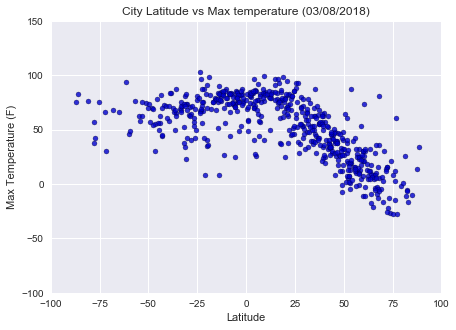

In [12]:
# plot scatter plots to showcase the relationship between Temperature (F) vs. Latitude

# Use Seaborn library to set the size and look of the plot
sns.set_style("darkgrid", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(7,5)})

# x and y axis data
lat_x = weather_data_df["Latitude"]
max_temp_y = weather_data_df["Max Temps(F)"]

# plot the graph
plt.scatter(lat_x, max_temp_y, s=25, marker="o", facecolors="mediumblue", 
            edgecolors="black", alpha=0.8)

# get current date for the plot title
today_date = time.strftime("%m/%d/%Y")

# set the x and y axis limits and labels and chart title     
plt.xlim(-100,100)
plt.ylim(-100,150)
plt.title(f"City Latitude vs Max temperature ({today_date})")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")

plt.savefig('TempvsLat.png')
plt.show()


## Latitude vs Humidity Plot

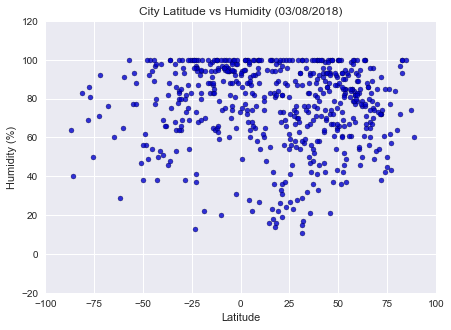

In [13]:
# plot scatter plots to showcase the relationship between Humidity (%) vs. Latitude

# Use Seaborn library to set the size and look of the plot
sns.set_style("darkgrid", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(7,5)})

# x and y axis data
lat_x = weather_data_df["Latitude"]
hum_y = weather_data_df["Humidity(%)"]

# plot the graph
plt.scatter(lat_x, hum_y, s=25, marker="o", facecolors="mediumblue", 
            edgecolors="black", alpha=0.8)

# get current date for the plot title
today_date = time.strftime("%m/%d/%Y")

# set the x and y axis limits and labels and chart title     
plt.xlim(-100,100)
plt.ylim(-20,120)
plt.title(f"City Latitude vs Humidity ({today_date})")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")

plt.savefig('HumidityvsLat.png')
plt.show()



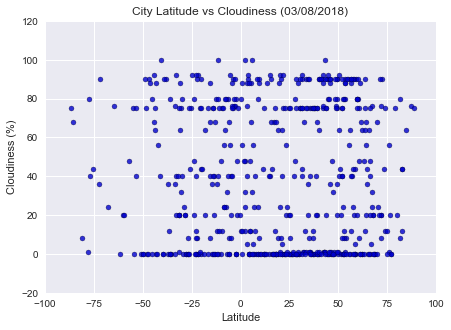

In [14]:
# plot scatter plots to showcase the relationship between Cloudiness (%) vs. Latitude

# Use Seaborn library to set the size and look of the plot
sns.set_style("darkgrid", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(7,5)})

# x and y axis data
lat_x = weather_data_df["Latitude"]
clou_y = weather_data_df["Cloudiness(%)"]

# plot the graph
plt.scatter(lat_x, clou_y, s=25, marker="o", facecolors="mediumblue", 
            edgecolors="black", alpha=0.8)

# get current date for the plot title
today_date = time.strftime("%m/%d/%Y")

# set the x and y axis limits and labels and chart title     
plt.xlim(-100,100)
plt.ylim(-20,120)
plt.title(f"City Latitude vs Cloudiness ({today_date})")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")

plt.savefig('CloudinessvsLat.png')
plt.show()

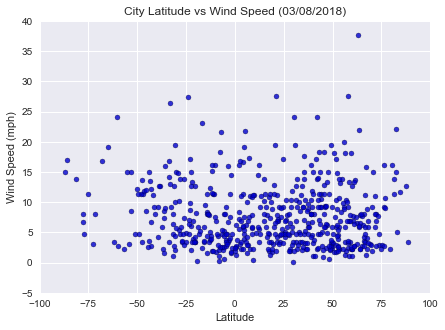

In [15]:
# plot scatter plots to showcase the relationship between Wind Speed (mph) vs. Latitude

# Use Seaborn library to set the size and look of the plot
sns.set_style("darkgrid", {'grid.linestyle': '--'})
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 2} 
sns.set(rc={'figure.figsize':(7,5)})

# x and y axis data
lat_x = weather_data_df["Latitude"]
win_sp_y = weather_data_df["Wind Speed(mph)"]

# plot the graph
plt.scatter(lat_x, win_sp_y, s=25, marker="o", facecolors="mediumblue", 
            edgecolors="black", alpha=0.8)

# get current date for the plot title
today_date = time.strftime("%m/%d/%Y")

# set the x and y axis limits and labels and chart title     
plt.xlim(-100,100)
plt.ylim(-5,40)
plt.title(f"City Latitude vs Wind Speed ({today_date})")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.savefig('WindSpeedvsLat.png')
plt.show()